In [2]:
%cd ../..

/home/ania/BridgeHand2Vec


### Opening bid classification

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.manifold import TSNE
from bh2vec.vectors_net import VectorsNetNorm
from bh2vec.tools import hand_to_vec, predict_tricks, vec_to_hand, load_vectors_for_hands

In [4]:
sns.set_style('whitegrid')

In [5]:
PATH = 'evaluation/data/openings'

In [6]:
df_train = pd.read_csv(os.path.join(PATH, 'train.csv'), sep=';', index_col=0)
df_test = pd.read_csv(os.path.join(PATH, 'test.csv'), sep=';', index_col=0)

In [7]:
df_train.reset_index(inplace=True, drop=True)
df_train

,PBN,OPENING
0,KQJ4.7.AT87.KQ74,1D
1,QT943.7654.42.A7,PASS
2,AJ7.AQ8754.T4.J5,1H
3,AT987.Q86.KQ4.43,1S
4,J84.T87.6543.QJ9,PASS
...,...,...
995,QT7.AQ9.QT9.T875,PASS
996,AJ3.AJT76.753.K3,1H
997,K972.98.AKJ.A842,1N
998,4.J52.A85.KJT976,PASS


In [8]:
df_test.reset_index(inplace=True, drop=True)
df_test

,PBN,OPENING
0,6.AJT.AJT862.AKQ,1C
1,AKQJ42.A.764.JT6,1S
2,J953.K962.653.A4,PASS
3,AQJ3.KJ.64.KJT85,1C
4,QJ872.984.A4.K75,PASS
...,...,...
208,QJT4.J8.QJ64.743,PASS
209,K93.872.J9763.A5,PASS
210,KJ9.Q54.J94.8732,PASS
211,5.KT.Q984.AKQ976,1C


In [9]:
df_train['OPENING'].value_counts()

PASS    549
1C      127
1H       76
1D       64
1S       64
1N       51
2C       22
2D       14
3C       11
2S        6
3D        4
2H        3
3S        3
2N        3
4H        2
3H        1
Name: OPENING, dtype: int64

In [10]:
df_test['OPENING'].value_counts()

PASS    116
1C       33
1S       18
1D       15
1H       10
2C        7
1N        5
2H        3
2D        2
3D        2
2S        1
3C        1
Name: OPENING, dtype: int64

In [11]:
sorter = ['PASS', '1C', '1D', '1H', '1S', '1N', '2C', '2D', '2H', '2S', '2N', '3C', '3D', '3H', '3S', '4H']

In [12]:
df_train['OPENING'] = df_train['OPENING'].astype("category")
df_train['OPENING'] = df_train['OPENING'].cat.set_categories(sorter)

In [13]:
df_train.sort_values(['OPENING'])

,PBN,OPENING
346,Q72.K5.JT7.A8532,PASS
384,832.AK97.73.J762,PASS
610,K87632.65.T9.T92,PASS
382,JT72.KJ.A7632.42,PASS
381,85.73.KT87.K9874,PASS
...,...,...
801,JT9853.8.T9643.8,3S
172,JT96543.2.4.JT42,3S
129,KQJ5432.932.72.J,3S
316,.KQJT732.9.T9654,4H


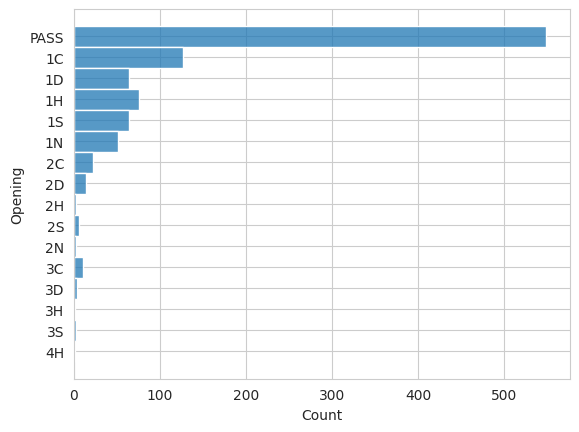

In [14]:
ax = sns.histplot(data=df_train, y="OPENING");
ax.set(ylabel='Opening');

In [16]:
PATH = 'models/vec5_batch_norm.pth'
net = VectorsNetNorm()
net.load_state_dict(torch.load(PATH))
net.eval()
vec_train = load_vectors_for_hands(net, df_train, hand_col='PBN')
vec_test = load_vectors_for_hands(net, df_test, hand_col='PBN')

In [17]:
vec_cols = ['vec' + str(i) for i in range(8)]
emb_cols = ['emb0', 'emb1']
df_train[vec_cols] = vec_train
df_test[vec_cols] = vec_test

#### T-SNE plot

In [18]:
vec_embedded_train = TSNE(n_components=2, learning_rate='auto', init='random', method='exact',
                          perplexity=10, n_iter=1000, random_state=0).fit_transform(vec_train)

In [19]:
df_train[emb_cols] = vec_embedded_train

In [20]:
df_plot = df_train[df_train['OPENING'].isin(['PASS', '1C', '1D', '1H', '1S', '1N', '2C', '2D', '2H', '2S'])].copy()

In [21]:
df_plot['OPENING'] = df_plot['OPENING'].astype('str')
df_plot['OPENING'] = df_plot['OPENING'].astype("category")
sorter2 = ['PASS', '1C', '1D', '1H', '1S', '1N', '2C', '2D', '2H', '2S']
df_plot['OPENING'] = df_plot['OPENING'].cat.set_categories(sorter2)

In [22]:
sorter2

['PASS', '1C', '1D', '1H', '1S', '1N', '2C', '2D', '2H', '2S']

In [23]:
new_labels = ['pass', '$1\clubsuit$', '$1\diamondsuit$', '$1\heartsuit$', '$1\spadesuit$', '$1NT$', 
             '$2\clubsuit$', '$2\diamondsuit$', '$2\heartsuit$', '$2\spadesuit$']

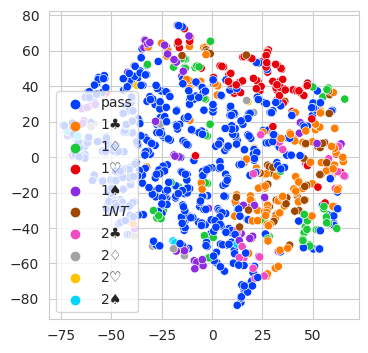

In [24]:
plt.figure(figsize=(4,4))
g = sns.scatterplot(data=df_plot, x='emb0', y='emb1', hue='OPENING', palette="bright");
g.set(xlabel=None);
g.set(ylabel=None);
leg = g.legend()
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
#g.legend(loc='upper left', bbox_to_anchor=(1, 1.02047), ncol=1);
#plt.savefig('results/figs/openings_tsne.pdf')

#### KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce

In [29]:
enc_ohe = ce.one_hot.OneHotEncoder(cols=['OPENING'], use_cat_names=True)
X_train = vec_train
y_train = enc_ohe.fit_transform(df_train['OPENING'])

In [30]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [31]:
X_test = vec_test
y_test = enc_ohe.transform(df_test['OPENING'])

In [32]:
neigh.score(X_test, y_test)

0.6854460093896714

#### Controversial openings

In [41]:
def print_nearest(hand, n=5):
    hand_vec = hand_to_vec(net, hand).reshape(1, -1)
    dist, idx = neigh.kneighbors(hand_vec, n_neighbors=n, return_distance=True)
    idx = idx.reshape(-1,).tolist()
    return df_train.iloc[idx][['PBN', 'OPENING']], dist

In [42]:
hands, dist = print_nearest('AT65.KT65.KJ3.65', n=10)
print(hands)
print(dist)

                  PBN OPENING
498  AT98.Q975.K72.95    PASS
448  Q974.AQ92.QJ2.83      1C
436  Q87.K983.AQ6.643    PASS
3    AT987.Q86.KQ4.43      1S
601  Q32.AJ54.K974.J2    PASS
873  AT82.K63.AJT.965      1C
939  QT85.AT7.K75.865    PASS
532  AJ2.K854.K65.984    PASS
683  A742.Q97.K97.432    PASS
895  AT863.QJ4.AQ83.9      1S
[[0.93459229 0.9719548  1.02938767 1.23365574 1.25121629 1.31605957
  1.36316919 1.3665158  1.37638345 1.38060587]]


In [43]:
hands, dist = print_nearest('AK8765.Q76.J65.6', n=10)
print(hands)
print(dist)

                  PBN OPENING
973  KJT97.Q963.A65.9    PASS
530  KQT73.A74.J976.Q      1S
834  AQT54.T82.JT2.64    PASS
866  AQJT63.K8.9732.4      1S
232  AQJT6.J73.9864.J    PASS
112  AQJ65.K962.84.83    PASS
741  QJ97.A985.JT4.72    PASS
253  KQJT7.A4.JT84.74      1S
290  AT8432.K63.Q98.Q    PASS
31   AQ8743.93.T32.T6      2D
[[1.15186581 1.30750875 1.31098035 1.31116849 1.31575709 1.48348101
  1.52293762 1.55792368 1.57572409 1.57980782]]


In [44]:
hands, dist = print_nearest('AQ765.K5.QJ5.A65', n=10)
print(hands)
print(dist)

                  PBN OPENING
124  KQT32.K9.AJ9.KT4      1N
221  AQ94.A86.QJ5.Q95      1N
960  AJT65.A4.K86.A73      1S
278  KT75.A3.KJ85.K64      1C
706  AJ9764.KQ.K83.A5      1C
158  QJ73.AK.QJ5.A632      1N
265  QJ83.Q74.AQ5.AT8      1N
552  KJ92.A6.AJ832.Q7      1D
831  KT53.A76.QJ94.A3      1C
447  AT53.A65.J85.K83      1C
[[1.21225028 1.22066906 1.2502347  1.29681825 1.43087654 1.44900451
  1.55278342 1.60669666 1.64369587 1.64527956]]


In [45]:
hands, dist = print_nearest('AJT2.KQ.65.QJ654', n=10)
print(hands)
print(dist)

                  PBN OPENING
434  KT72.AK6.3.J8732      1C
561  AQ5.QJ.852.AJ642      1C
921  AJ72.KJT.3.AJ973      2C
906  KQJT7.QT.2.AT852      1S
901  Q852.AQ.983.Q965    PASS
346  Q72.K5.JT7.A8532    PASS
282  A63.KQ.A87.QJ865      1N
147  QT4.KT7.432.A964    PASS
227  AJT2.KQ8.74.AQ32      1N
732  AKT95.K2.982.QJ3      1S
[[1.48478614 1.65585817 1.66308108 1.73246183 1.78405413 1.86536944
  1.94203827 1.95135535 1.98743489 1.99256783]]


In [46]:
hands, dist = print_nearest('AK65.AK65.K765.6', n=10)
print(hands)
print(dist)

                  PBN OPENING
327  AQT7.AQ83.QJ97.6      1D
516  AJ65.AQ62.J654.8      1D
762  KQJ9.A96.A742.62      1N
76   KQ93.A732.AT85.Q      1D
383  AKJ54.KQ6.K86.T4      1S
728  A542.AK6.AJ942.J      1D
369  AQ74.AJ62.AQJ.T2      1C
50   AQ4.A854.KT943.Q      1D
473  AQ852.AQT76.AQ4.      1C
21   KQ87.AJ.AJ862.J8      1D
[[0.93659098 1.41666595 1.59932097 1.6148123  1.87575006 1.90658056
  1.96225876 1.97651248 2.00515929 2.00564474]]
